# 1. Data Collection

We are focusing on synopsis/summary (Overview) of the content to extract clues related to generes. In this section we are processing raw data and keeping only information we need.

In [2]:
import pandas as pd

#--> Read CSV file. 
df = pd.read_csv("./lite-dev-mlcontent_2018/features.csv.dev", delimiter="|", error_bad_lines=True)
df2 = pd.read_csv("./lite-dev-mlcontent_2018/labels.csv.dev",  delimiter="|", error_bad_lines=True)


In [126]:
from sklearn.preprocessing import MultiLabelBinarizer

#--> Projecting columns we are interesting in.
data = df[['channel_name', 'program_name', 'keywords']]
description = data[["channel_name", 'program_name', 'keywords']].apply(lambda x: ' '.join(x), axis=1).values
genres = df2.genre.map(lambda x: x.strip().lower()).str.split(" ").values

print(description.shape)
print(genres.shape)

lb = MultiLabelBinarizer()
genres = lb.fit_transform(genres)
print(genres.shape)

# #--> Dropping all rows where either genere or overview 
# data = data.dropna(subset=['overview', 'genres'])

# #--> Encode all generes
# genres =  pd.get_dummies(data['genres'].str.split("|", expand=False).apply(pd.Series).stack()).sum(level=0)

(9430,)
(9430,)
(9430, 64)


In [127]:
description[0]

"fnchd Happening Now The president's deadline come:1,follow the daca issue:1,set a telephone hot line:1,resume the debate:1,White house secretary called:1,bring this thing:1,The court rulings nullify:1,expand the daca program:1,stop the program:1,Donald Trump working:1"

# 2. Cleanup and Preprocess
We are using keras' ```Tokenizer``` and ```pad_sequence``` utility to encode our input to fixed size matrice.


In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import numpy as np

Using TensorFlow backend.


In [129]:
#--> Each sequence in the dataset
seq_len = 100

#--> Size of the common vacabulary 
max_vocab = 5000

#--> Embeding dimension 
embedding_dim = 100

#--> From columns to numpy array
X_train = description
y_train = genres

#--> Tokenizing 
tokenzier = Tokenizer(num_words=max_vocab)
tokenzier.fit_on_texts(X_train)

#--> Word index NOTE: We need to use the same word index for testing as well
idx = tokenzier.index_docs

#--> Get the data vectorize
X_train = tokenzier.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=seq_len)

#--> Spliting for 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.05)

print("[INFO] Training Set X:{}, y:{}. Testing set X:{}, y:{}"
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


[INFO] Training Set X:(8958, 100), y:(8958, 64). Testing set X:(472, 100), y:(472, 64)


# 3. Baseline

In [90]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# GloVe
https://nlp.stanford.edu/projects/glove/

Using GloVe.6B.100d. as the first embedding layer and experimenting with the following approaaches
1. GloVe pre-trained layer(Frozen) with Dense classifier layer.
2. GloVe pre-trained layer(Frozen) with one or two convolution layers on tope.
3. Fine tune embedding to see if there's any improvement.
4. Create our own embedding layer and train it from scratch.

In [111]:
# This particular block of code is from keras' official blog.
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

import os
import numpy as np

embeddings_index = {}

#-- 1. Loading the indices
f = open(os.path.join("./glove.6B", 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#-- 2. Creating embedding matrix
embedding_matrix = np.zeros((len(idx) + 1, 50))

for word, i in idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print('[INFO] Found %s word vectors.' % len(embeddings_index))
print('[INFO] Found %s elements in matrix.' % len(embedding_matrix))


[INFO] Found 400000 word vectors.
[INFO] Found 22191 elements in matrix.


In [121]:
model = Sequential()
model.add(Embedding(input_dim=len(idx)+1, 
                    output_dim=50,                     
                    input_length=seq_len,
                    weights = [embedding_matrix],
                    trainable=True))

model.add(Conv1D(32, 3, activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(32, 3, activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(32, 5, activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(32, 5, activation="relu"))
model.add(MaxPooling1D(2))

model.add(Flatten())
#model.add(Dense(1024, activation="relu"))
model.add(Dense(len(lb.classes_), activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 100, 50)           1109550   
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 98, 32)            4832      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 47, 32)            3104      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 19, 32)            5152      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 9, 32)             0         
__________

# 4. Our Model

In [130]:
from keras.models import Sequential
from keras.layers import Conv1D, Embedding, GlobalMaxPooling1D, Dense, Flatten, MaxPooling1D, Dropout

#print(X_train[0])

model = Sequential()
model.add(Embedding(input_dim=len(idx)+1, output_dim=64, input_length=seq_len))
model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(len(lb.classes_), activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 100, 64)           1421120   
_________________________________________________________________
flatten_35 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                409664    
Total params: 1,830,784
Trainable params: 1,830,784
Non-trainable params: 0
_________________________________________________________________


# Training
```
>>> from sklearn.model_selection import KFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([1, 2, 3, 4])
>>> kf = KFold(n_splits=2)
>>> kf.get_n_splits(X)
2
>>> print(kf)  
KFold(n_splits=2, random_state=None, shuffle=False)
>>> for train_index, test_index in kf.split(X):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]
```

In [135]:
from sklearn.model_selection import KFold

epochs = 3
file_name = "./best_model.hdf5"
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

kf = KFold(n_splits=3)

for train_index, test_index in kf.split(X_train):
    batch_x, batch_y = X_train[train_index], y_train[train_index]
    batch_xx, batch_yy = X_train[test_index], y_train[test_index]
    H = model.fit(X_train, y_train, epochs=epochs, validation_data=(batch_xx, batch_yy))

#H = model.fit(X_train, y_train, epochs=epochs, validation_split=0.05, batch_size=32)
model.save(file_name)

Train on 8958 samples, validate on 2986 samples
Epoch 1/3
8958/8958 [==============================] - 8s 853us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 6.5246e-04 - val_acc: 1.0000
Epoch 2/3
8958/8958 [==============================] - 6s 714us/step - loss: 8.4069e-04 - acc: 0.9999 - val_loss: 4.5493e-04 - val_acc: 1.0000
Epoch 3/3
8958/8958 [==============================] - 6s 719us/step - loss: 4.5949e-04 - acc: 1.0000 - val_loss: 3.1737e-04 - val_acc: 1.0000
Train on 8958 samples, validate on 2986 samples
Epoch 1/3
8958/8958 [==============================] - 6s 715us/step - loss: 2.9589e-04 - acc: 1.0000 - val_loss: 1.6521e-04 - val_acc: 1.0000
Epoch 2/3
8958/8958 [==============================] - 6s 714us/step - loss: 2.3706e-04 - acc: 1.0000 - val_loss: 1.1124e-04 - val_acc: 1.0000
Epoch 3/3
8958/8958 [==============================] - 6s 719us/step - loss: 1.8499e-04 - acc: 1.0000 - val_loss: 8.5735e-05 - val_acc: 1.0000
Train on 8958 samples, validate on 2986 samples
Ep

ImportError: `save_model` requires h5py.

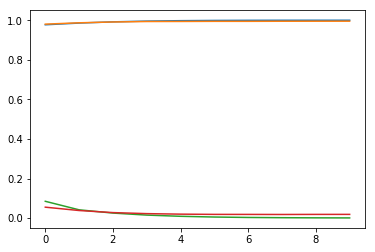

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(epochs), H.history["acc"])
plt.plot(np.arange(epochs), H.history["val_acc"])
plt.plot(np.arange(epochs), H.history["loss"])
plt.plot(np.arange(epochs), H.history["val_loss"])

# 5. Evaluate
Here we need to show Accuracy, precision and may be F1 score. We will draw some charts to make sure overfitting and underfitting is not happening.

We will use our train/test split data here to evaluate.

In [136]:
#Model evluation 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

model.evaluate(X_test, y_test)

#model.score(X_test, y_test)
# predictions = model.predict(X_test)

# print(predictions[0])

472/472 [==============================] - 0s 83us/step


[0.01830699016987267, 0.9954978813559322]

# 6. Test and submit 
Generate the final test results, format and submit

In [137]:
# Final test code goes here
test_df = pd.read_csv("./lite-eval-mlcontent_2018/features.csv.eval", delimiter="|", error_bad_lines=True)
test_data = test_df[['channel_name', 'program_name', 'keywords']]
test_description = test_data[['program_name', 'keywords']].apply(lambda x: ' '.join(x), axis=1).values

eval_data = tokenzier.texts_to_sequences(test_description)
eval_data = pad_sequences(eval_data, maxlen=seq_len)

print(eval_data.shape)

predictions = model.predict(eval_data)

header = "|etag|" + "|".join(lb.classes_)+"|\n"

output_file = "./output/prediction.csv"

file = open(output_file, "w")
# |etag| news | sports | ... |
file.write(header)

for i in range(len(predictions)):
    line = "|"+test_df["etag"][i]+"|"+"|".join(["{:.4f}".format(a) for a in predictions[i]])+"|"
    file.write(line)
    file.write("\n")
file.close()



(3144, 100)
